In [ ]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
base_dir = "C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00"

real_dir = os.path.join(base_dir, 'real')
fake_dir = os.path.join(base_dir, 'fake')

real_frames = os.path.join(real_dir, "real_frames")
fake_frames = os.path.join(fake_dir, "fake_frames")

real_faces = os.path.join(real_dir, "real_faces")
fake_faces = os.path.join(fake_dir, "fake_faces")

real_faces_dir = os.path.join(real_dir, "real_faces")
fake_faces_dir = os.path.join(fake_dir, "fake_faces")

train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [ ]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.4
)

validation_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=20,
                                                    class_mode='binary',
                                                          shuffle=False)

test_generator = validation_data_generator.flow_from_directory(test_dir,
                                                  target_size=(224, 224),
                                                  batch_size=20,
                                                  class_mode='binary',
                                                          shuffle=False)

Found 10118 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


In [ ]:
from sklearn.metrics import classification_report

def create_classification_report(test_generator):
    # Get the model predictions on the test data
    y_pred = model.predict(test_generator)

    # Convert the predicted probabilities to class labels (0 or 1)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Get the true labels from the test data generator
    y_true = test_generator.classes

    return classification_report(y_true, y_pred_binary)

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(test_generator):
    # Predict the classes for the test data
    y_pred = model.predict(test_generator)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Get the true labels for the test data
    y_true = test_generator.classes

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    return plt

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def create_roc_curve(y_true, y_pred):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    return plt

In [ ]:
### DenseNet 151 Model

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
def create_model(learning_rate=0.001, optimizer='adam'):

    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the layers of the base model
    for layer in densenet_base.layers:
        layer.trainable = False
    x = densenet_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=densenet_base.inputs, outputs=predictions)

    model.compile(optimizer=Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


In [ ]:
model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

C:\Users\khors\miniconda3\envs\test\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 te)                                                              'conv4_block1_2_conv[0][0]']    
                                                                                                  
 conv4_block2_0_bn (BatchNormal  (None, 14, 14, 288)  1152       ['conv4_block1_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_0_relu (Activatio  (None, 14, 14, 288)  0          ['conv4_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 128)  36864       ['conv4_block2_0_relu[0][0]']    
                                                                                                  
 conv4_blo

In [ ]:
import scipy
from tensorflow.keras.callbacks import EarlyStopping

with tf.device("/GPU:0"):
    batch_size = 32
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.n // batch_size,
        epochs=20,
        validation_steps=test_generator.n // batch_size,
        validation_data=test_generator,
        batch_size=batch_size,
        callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
    )

Epoch 1/20
316/316 [==============================] - 82s 234ms/step - loss: 0.6878 - accuracy: 0.5957 - val_loss: 1.2071 - val_accuracy: 0.1753
Epoch 2/20
316/316 [==============================] - 72s 229ms/step - loss: 0.6355 - accuracy: 0.6485 - val_loss: 0.3836 - val_accuracy: 0.8741
Epoch 3/20
316/316 [==============================] - 71s 225ms/step - loss: 0.5769 - accuracy: 0.6936 - val_loss: 1.0618 - val_accuracy: 0.3335
Epoch 4/20
316/316 [==============================] - 70s 222ms/step - loss: 0.5728 - accuracy: 0.6964 - val_loss: 0.3729 - val_accuracy: 0.8696
Epoch 5/20
316/316 [==============================] - 71s 226ms/step - loss: 0.5523 - accuracy: 0.7119 - val_loss: 0.9059 - val_accuracy: 0.4304
Epoch 6/20
316/316 [==============================] - 70s 221ms/step - loss: 0.5422 - accuracy: 0.7271 - val_loss: 0.4257 - val_accuracy: 0.8272
Epoch 7/20
316/316 [==============================] - 70s 222ms/step - loss: 0.5286 - accuracy: 0.7327 - val_loss: 0.5566 - val_ac

In [ ]:
model.save("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Saved Models\/DenseNet121.h5")

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}, Test Loss: {test_loss}")


127/127 [==============================] - 8s 61ms/step - loss: 0.5497 - accuracy: 0.7222
Test Accuracy: 0.722244143486023, Test Loss: 0.5497032403945923


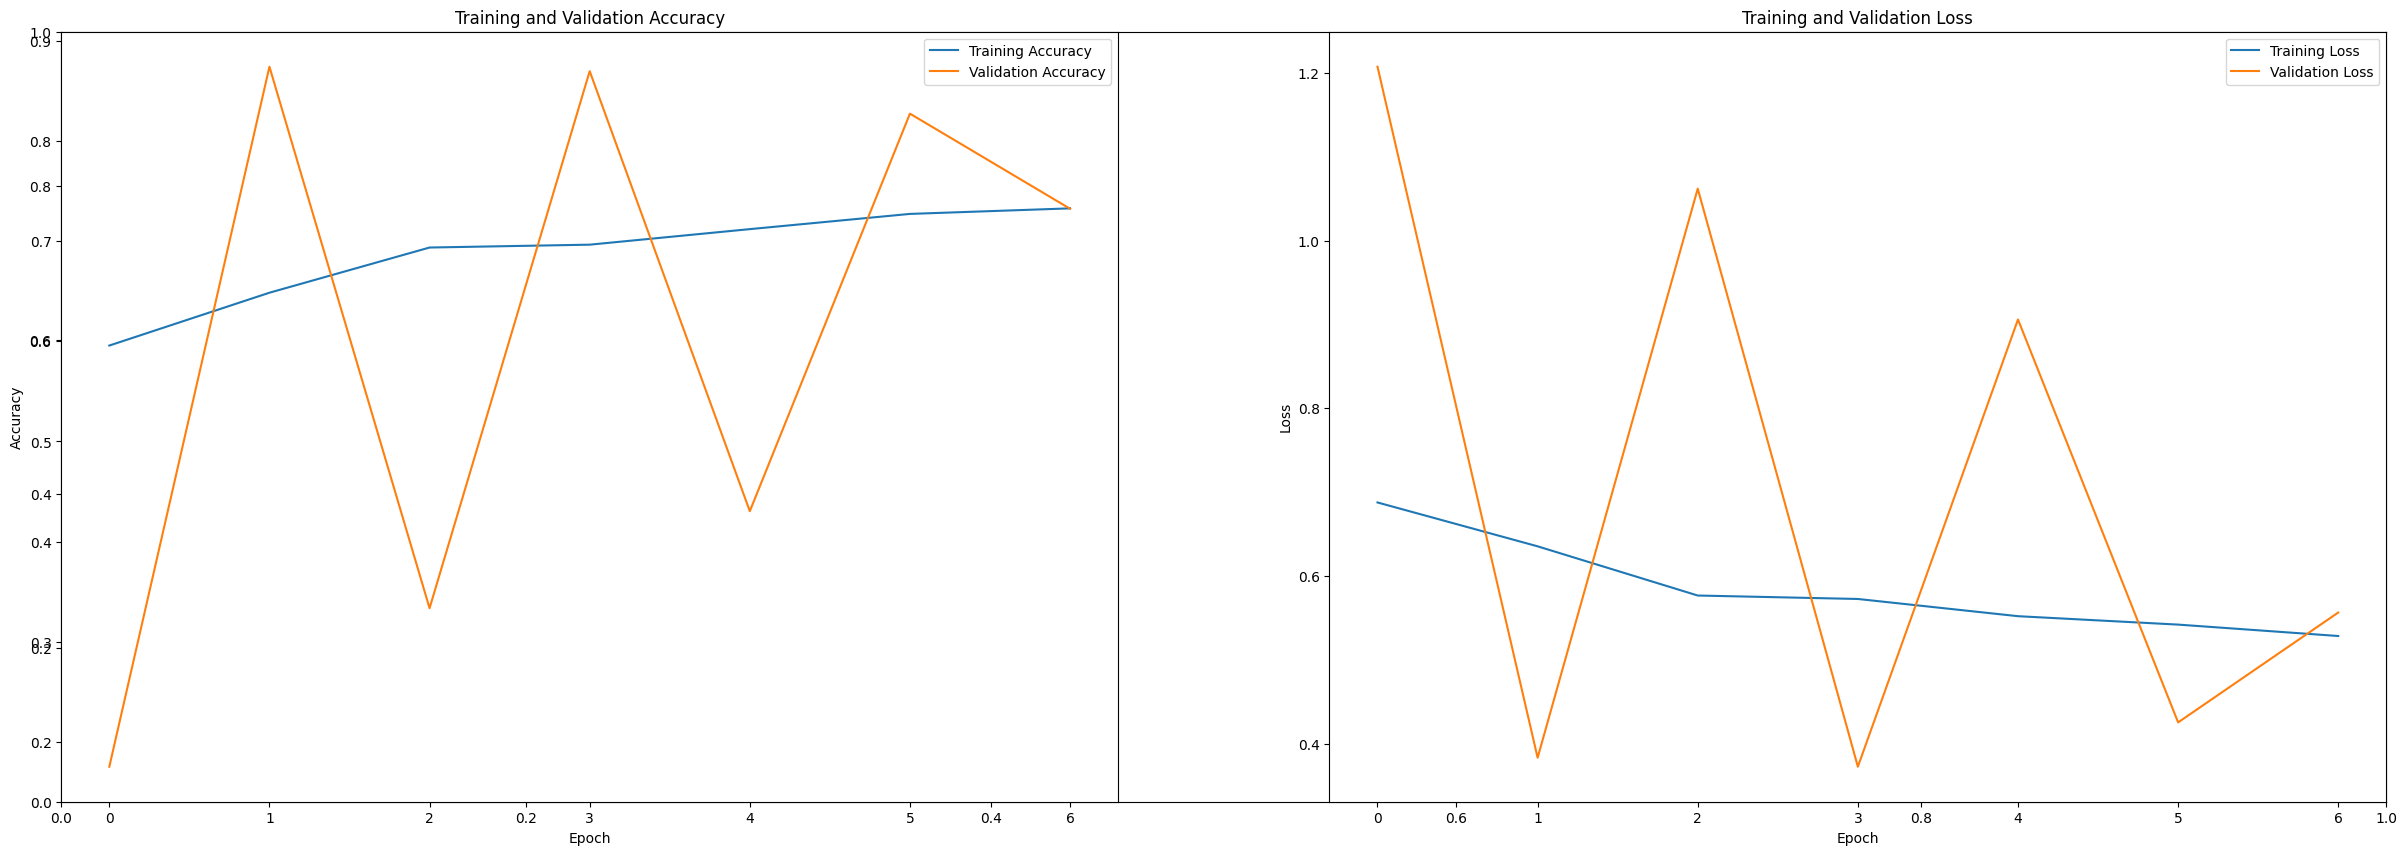

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()

127/127 [==============================] - 8s 52ms/step
[[0.05746321]
 [0.19014136]
 [0.03894397]
 ...
 [0.22205344]
 [0.50740653]
 [0.33159605]]


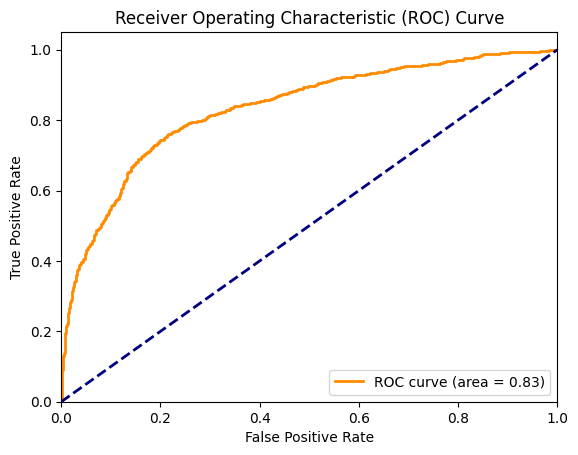

In [ ]:
# Get true labels
y_true = test_generator.classes

# Get predicted probabilities
y_pred = model.predict(test_generator)
print(y_pred)
y_pred = y_pred.flatten()
# y_pred = y_pred[:, 1]
create_roc_curve(y_true, y_pred).show()

127/127 [==============================] - 7s 52ms/step


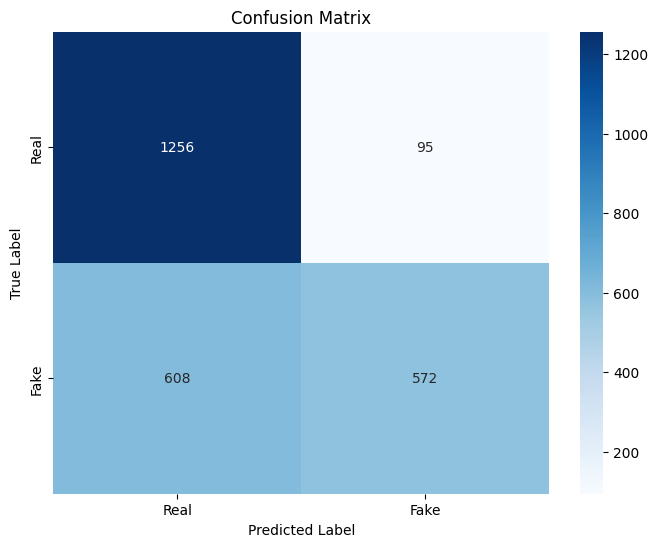

In [ ]:
create_confusion_matrix(test_generator).show()

In [ ]:
# create_roc_curve(test_generator).show()

In [ ]:
print(create_classification_report(test_generator))

127/127 [==============================] - 7s 53ms/step
              precision    recall  f1-score   support

           0       0.67      0.93      0.78      1351
           1       0.86      0.48      0.62      1180

    accuracy                           0.72      2531
   macro avg       0.77      0.71      0.70      2531
weighted avg       0.76      0.72      0.71      2531



### Detection

###
0 - Fake
1 - Real

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 2s 2s/step
[[0.4245687]]


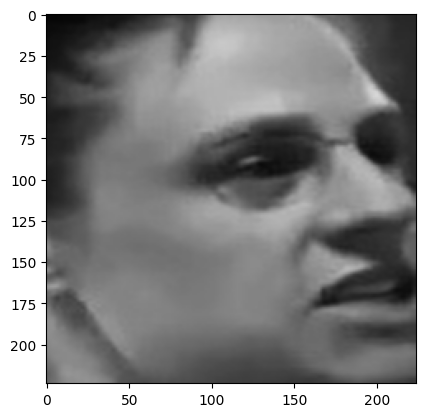

In [ ]:
import matplotlib.pyplot as plt
import cv2

#img2 = cv2.imread("C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00\/real\/real_faces\/face_0_frame_apedduehoy_0010.jpg", cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('C:\/Users\/khors\/Downloads\/DeepFake Face Recognition\/Datasets\/dfdc_train_part_00\/fake\/fake_faces\/face_0_frame_hvqfhieetb_0002.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img2)

type(img2)

img = cv2.cvtColor(img2, cv2.COLOR_GRAY2RGB)
resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_LANCZOS4)
print(resized.shape)

img_batch = np.expand_dims(resized, 0)
print(img_batch.shape)

plt.imshow(resized)

y_val_pred = model.predict(img_batch)

print(y_val_pred)


In [ ]:
train_generator.classes

array([0, 0, 0, ..., 1, 1, 1])